In [1]:
import pystac_client
import planetary_computer
import odc.stac
import matplotlib.pyplot as plt
from pystac.extensions.eo import EOExtension as eo

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [3]:
bbox_of_interest = [89.419391,22.732522,89.671905,22.853430]
time_of_interest = "2022-01-01/2022-12-31"

In [4]:
search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 1}},
)

items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 25 Items


In [5]:
selected_item = items[5] # min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LC08_L2SP_138044_20221122_02_T1 from 2022-11-22 with 0.1% cloud cover


In [6]:
max_key_length = len(max(selected_item.assets, key=len))
for key, asset in selected_item.assets.items():
    print(f"{key.rjust(max_key_length)}: {asset.title}")

              qa: Surface Temperature Quality Assessment Band
             ang: Angle Coefficients File
             red: Red Band
            blue: Blue Band
            drad: Downwelled Radiance Band
            emis: Emissivity Band
            emsd: Emissivity Standard Deviation Band
            trad: Thermal Radiance Band
            urad: Upwelled Radiance Band
           atran: Atmospheric Transmittance Band
           cdist: Cloud Distance Band
           green: Green Band
           nir08: Near Infrared Band 0.8
          lwir11: Surface Temperature Band
          swir16: Short-wave Infrared Band 1.6
          swir22: Short-wave Infrared Band 2.2
         coastal: Coastal/Aerosol Band
         mtl.txt: Product Metadata File (txt)
         mtl.xml: Product Metadata File (xml)
        mtl.json: Product Metadata File (json)
        qa_pixel: Pixel Quality Assessment Band
       qa_radsat: Radiometric Saturation and Terrain Occlusion Quality Assessment Band
      qa_aerosol: Aeros

In [7]:
bands_of_interest = ["nir08", "red", "green", "blue", "qa_pixel"]
data = odc.stac.stac_load(
    [selected_item], bands=bands_of_interest, bbox=bbox_of_interest
).isel(time=0)
data

<xarray.Dataset>
Dimensions:      (y: 462, x: 873)
Coordinates:
  * y            (y) float64 2.53e+06 2.53e+06 2.53e+06 ... 2.516e+06 2.516e+06
  * x            (x) float64 7.483e+05 7.483e+05 ... 7.744e+05 7.744e+05
    spatial_ref  int32 32645
    time         datetime64[ns] 2022-11-22T04:31:32.473675
Data variables:
    nir08        (y, x) uint16 14555 14379 15067 16654 ... 10402 10728 11459
    red          (y, x) uint16 10572 9572 9256 9134 9174 ... 8906 9326 9894 9944
    green        (y, x) uint16 10570 9941 9730 9720 ... 9309 9893 10638 10701
    blue         (y, x) uint16 9300 8812 8666 8602 8626 ... 8093 8331 8670 8714
    qa_pixel     (y, x) uint16 21824 21824 21824 21824 ... 21824 21824 21824

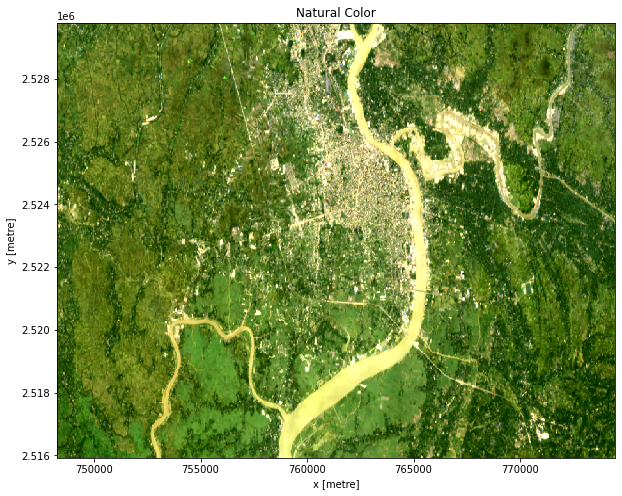

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))

data[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax)
ax.set_title("Natural Color");

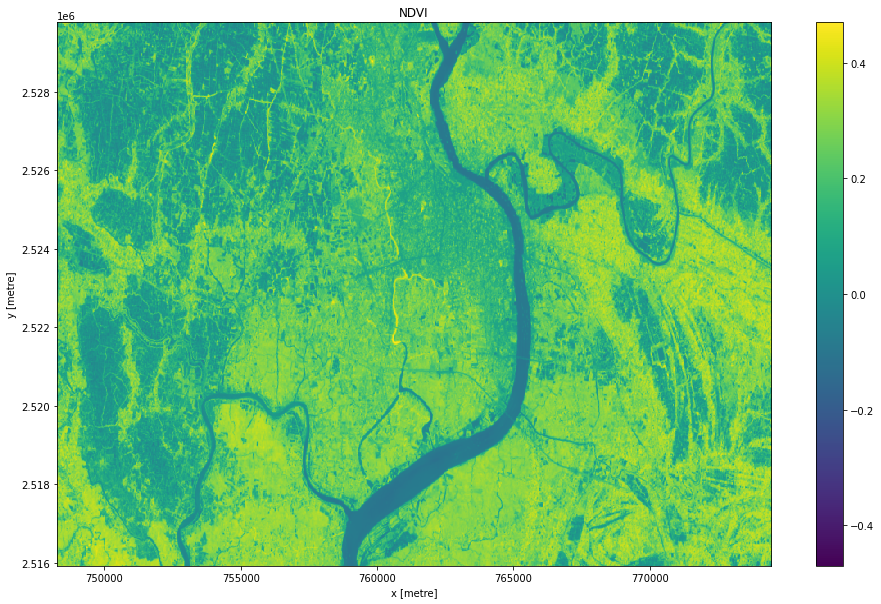

In [12]:
red = data["red"].astype("float")
nir = data["nir08"].astype("float")
ndvi = (nir - red) / (nir + red)

fig, ax = plt.subplots(figsize=(16, 10))
ndvi.plot.imshow(ax=ax, cmap="viridis")
ax.set_title("NDVI");